In [1]:
import pandas as pd
import numpy as np
import nltk
import json
from datasets import Dataset
from transformers import *
import torch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [2]:
import os

In [3]:
def strip_emoji(text):
    new_text = re.sub(emoji.get_emoji_regexp(), r"", text)
    return new_text
def remove_links(text):
    return re.sub(r'http\S+', '', text)

In [4]:
with open("../input/twitter-bot-detection/Twibot-20/Twibot-20/train.json") as f:
    train_json = json.load(f)
    train_df = pd.json_normalize(train_json, sep = '_')

In [5]:
train_df = train_df.explode('tweet')

In [6]:
# train_df.domain.apply(len).max() #not useful don't have in ukraine

In [7]:
train_df.head()

,ID,tweet,neighbor,domain,label,profile_id,profile_id_str,profile_name,profile_screen_name,profile_location,...,profile_profile_link_color,profile_profile_sidebar_border_color,profile_profile_sidebar_fill_color,profile_profile_text_color,profile_profile_use_background_image,profile_has_extended_profile,profile_default_profile,profile_default_profile_image,neighbor_following,neighbor_follower
0,17461978,RT @CarnivalCruise: 🎉 Are you ready to see wha...,NaN,"[Politics, Business, Entertainment]",0,17461978,17461978,SHAQ,SHAQ,"Orlando, FL",...,2FC2EF,181A1E,252429,666666,True,False,False,False,NaN,NaN
0,17461978,Who has time for receipts? Not me. @epson rece...,NaN,"[Politics, Business, Entertainment]",0,17461978,17461978,SHAQ,SHAQ,"Orlando, FL",...,2FC2EF,181A1E,252429,666666,True,False,False,False,NaN,NaN
0,17461978,Steady wants to encourage you to invest in you...,NaN,"[Politics, Business, Entertainment]",0,17461978,17461978,SHAQ,SHAQ,"Orlando, FL",...,2FC2EF,181A1E,252429,666666,True,False,False,False,NaN,NaN
0,17461978,"Good one, @rishid. But let’s see if y'all can ...",NaN,"[Politics, Business, Entertainment]",0,17461978,17461978,SHAQ,SHAQ,"Orlando, FL",...,2FC2EF,181A1E,252429,666666,True,False,False,False,NaN,NaN
0,17461978,#lsunationalchamps\n,NaN,"[Politics, Business, Entertainment]",0,17461978,17461978,SHAQ,SHAQ,"Orlando, FL",...,2FC2EF,181A1E,252429,666666,True,False,False,False,NaN,NaN


In [8]:
train_df.tweet.iloc[1058]

'@ghostingbieber Forever\n'

In [9]:
ukraine = pd.read_csv("../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineCombinedTweetsDeduped20220227-131611.csv.gzip",
                      compression = 'gzip')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
ukraine.text.iloc[0]

'Footage of the airport bombing in Ivano-Frankivsk. #Ukraine #Russia https://t.co/MLVuNyPItI'

In [11]:
ukraine.hashtags.iloc[0]

"[{'text': 'Ukraine', 'indices': [68, 76]}, {'text': 'Russia', 'indices': [77, 84]}]"

In [12]:
ukraine.columns

Index(['Unnamed: 0', 'userid', 'username', 'acctdesc', 'location', 'following',
       'followers', 'totaltweets', 'usercreatedts', 'tweetid',
       'tweetcreatedts', 'retweetcount', 'text', 'hashtags', 'language',
       'coordinates', 'favorite_count', 'extractedts'],
      dtype='object')

In [13]:
train_df.columns

Index(['ID', 'tweet', 'neighbor', 'domain', 'label', 'profile_id',
       'profile_id_str', 'profile_name', 'profile_screen_name',
       'profile_location', 'profile_profile_location', 'profile_description',
       'profile_url', 'profile_entities', 'profile_protected',
       'profile_followers_count', 'profile_friends_count',
       'profile_listed_count', 'profile_created_at',
       'profile_favourites_count', 'profile_utc_offset', 'profile_time_zone',
       'profile_geo_enabled', 'profile_verified', 'profile_statuses_count',
       'profile_lang', 'profile_contributors_enabled', 'profile_is_translator',
       'profile_is_translation_enabled', 'profile_profile_background_color',
       'profile_profile_background_image_url',
       'profile_profile_background_image_url_https',
       'profile_profile_background_tile', 'profile_profile_image_url',
       'profile_profile_image_url_https', 'profile_profile_link_color',
       'profile_profile_sidebar_border_color',
       'profile

# to do extract hashtags

In [14]:
sample = train_df.sample(500).reset_index(drop = True)
X = sample[['tweet', 'label']]

In [15]:
X.columns = ['texts', 'labels']
X = X.dropna()
X.labels = X.labels.apply(int)

In [16]:
X.shape

(500, 2)

In [17]:
X.sample(3)

,texts,labels
90,RT @OpenCambridgeUK: Be sure to mark your cale...,0
188,@Jada__london 👊🏿❤️\n,0
182,@RoshaneSport @mjshrimper Surely it would’ve b...,0


<AxesSubplot:>

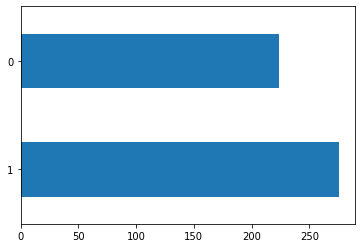

In [18]:
X.labels.value_counts().plot.barh()

In [19]:
X.texts.apply(len).min()

13

In [20]:
X.texts.apply(len).mean()

117.774

In [21]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp1f7jies6


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
creating metadata file for /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
https://huggingface.co/distilbert-base-uncased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmppfqlxv6n


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
creating metadata file for /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.0

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpg7lkp8t6


Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
creating metadata file for /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading

In [22]:
max_length = tokenizer.model_max_length
def tokenize(batch):
    return tokenizer(batch["texts"], padding=True, truncation=True,  max_length = max_length)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=2)
         .to(device))

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/huggingf

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
creating metadata file for /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight

In [24]:
def compute_metrics(pred):
    labels = pred.label_ids
    #map to 01
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    roc = roc_auc_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test= train_test_split(X, test_size = 0.4, random_state = 42)
train_ds = Dataset.from_pandas(X_train)
val_ds = Dataset.from_pandas(X_test)

In [26]:
# train_ds.remove_columns("__index_level_0__")

In [27]:
token_train = train_ds.map(tokenize, batched=True)
token_val = val_ds.map(tokenize, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [28]:
token_train = token_train.remove_columns(['texts', '__index_level_0__'])
token_val = token_val.remove_columns(['texts', '__index_level_0__'])

In [29]:
batch_size = 32
logging_steps = len(token_train) // batch_size
model_name = f"{model_ckpt}-finetune"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  report_to = "none",
                                  #evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  #logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

PyTorch: setting up devices


In [30]:
# import wandb
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wandb_key = user_secrets.get_secret("wandb_key")
# wandb.login(key=wandb_key)

In [31]:
# token_train.set_format('torch', columns = ['labels', 'input_ids', 'attention_mask'])

In [32]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=token_train,
                  #eval_dataset=token_val,
                  tokenizer=tokenizer)
trainer.train();

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss


In [33]:
batch = next(iter(token_train))

In [34]:
len(batch['attention_mask'])

231